In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import torchvision
import torchvision.transforms as T

from sklearn.model_selection import train_test_split

import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Import the dataset

In [ ]:
### MNIST data

# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')


labelsT   = torch.tensor( data[:,0] ).long()
data      = data[:,1:]
dataNorm  = data / np.max(data)
dataNormT = torch.tensor( dataNorm.reshape(dataNorm.shape[0],1,28,28) ).float()


train_data,test_data, train_labels,test_labels = train_test_split(dataNormT, labelsT, test_size=.1)


train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

batchsize    = 32
numbers_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
numbers_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
### FMNIST data

# transformations
transform = T.Compose([ T.ToTensor(), T.Normalize(.5,.5) ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize    = 32
fashion_train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
fashion_test_loader  = DataLoader(testset, batch_size=len(testset))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Create a model

In [ ]:
# create a class for the model
def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (28+2*1-5)/1 )+1 = 26/2 = 13 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (13+2*1-5)/1 )+1 = 11/2 = 5 (/2 b/c maxpool)

      expectSize = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
      expectSize = 20*int(expectSize**2)
      
      ### fully-connected layer
      self.fc1 = nn.Linear(expectSize,50)

      ### output layer
      self.out = nn.Linear(50,10)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):
      
      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1: {x.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2: {x.shape}') if self.print else None

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')
      
      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x
  
  
  net = mnistNet(printtoggle)
  

  lossfun = nn.CrossEntropyLoss()

  # optimizer (NOTE: Using SGD here to slow down learning!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.005)

  return net,lossfun,optimizer

# Create a  function that  trains the model

In [ ]:
# input the network and the number of epochs to train

def function2trainTheModel(net,train_loader,test_loader,numepochs=10):

    #initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []


    # LOOP OVER EPOCHS
    for epochi in range(numepochs):

        # loop over training data-batches
        net.train()
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat,axis=1)==y
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

            # end of batch loop.

            # now that we have trained through the batches get their average training accuracy
            trainAcc.append(np.mean(batchAcc))

            # and get average losses across the batches
            losses[epochi] = np.mean(batchLoss)

            # test accuracy
            net.eval()
            X,y = next(iter(test_loader))
            with torch.no_grad():
                yHat = net(X)
            
            # compute accuracy
            testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
        
        #end epochs
        return trainAcc,testAcc,losses,net



# Train source model on number and show the  results

In [ ]:
# create a new model
numberNet,lossfun,optimizer = createTheMNISTNet()

# train it on numbers data
trainAcc,testAcc,losses,numberNet = function2trainTheModel(numberNet,numbers_train_loader,numbers_test_loader,5)



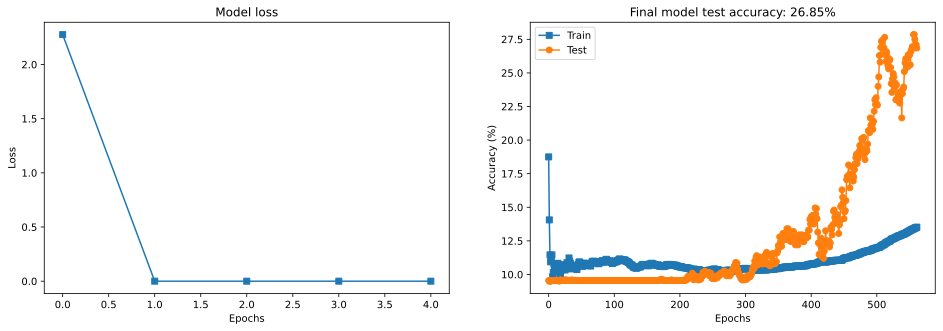

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Test the model on fashion datas

In [ ]:
# extract X,y from fashion test dataloader

X,y = next(iter(fashion_test_loader))
yHat = numberNet(X)

# the test
fashionAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
print(f'NUMBERNET performance on FASHION data: {fashionAcc:.2f}%')

NUMBERNET performance on FASHION data: 11.19%


# fine tune the model using one batch

In [ ]:
# create the  model
fashionNet,lossfun,optimizer = createTheMNISTNet()

# then replace all the weights in target model from  source model
for target,source in zip(fashionNet.named_parameters(),numberNet.named_parameters()):
    target[1].data = copy.deepcopy(source[1].data)
    

In [ ]:
# Note: you'd think that the following should work, but deepcopy() doesn't copy many features of classes.
# Try it and see what happens!
#DUDL_transfer_MNISTtoFMNIST = copy.deepcopy( numberNet )

In [ ]:
# now re-train the network on the numbers of data
trainAcc,testAcc,losses,fashionNet = function2trainTheModel(
    fashionNet,fashion_train_loader,fashion_test_loader,1)


print(f'numberNet TRAIN accuracy: {trainAcc[-1]:.2f}%')
print(f'numberNet TEST accuracy: {testAcc[-1]:.2f}%')


In [ ]:
print("losses:"losses)